# RNA Structure Benchmark Preprocessing & Utilities

This notebook:

1. Converts **ArchiveII** `.bpseq` files → `sequence, dot_bracket` CSV  
2. Converts **bpRNA-NF-15.0** raw CSV → the same format  
3. Implements encoding utilities (sequence & dot-bracket)  
4. Implements PyTorch Dataset classes + collate function  
5. Implements Nussinov dynamic programming decoder  
6. Runs sanity checks on both datasets


In [2]:
#Import necessary libraries
import os
import glob
from typing import List, Tuple

import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

print("PyTorch version:", torch.__version__)
device = "cuda" if torch.cuda.is_available() else "cpu"
device


PyTorch version: 2.9.1+cpu


'cpu'

In [3]:
from pathlib import Path

# This notebook lives in project_root/notebooks
NOTEBOOK_DIR = Path.cwd()
PROJECT_ROOT = NOTEBOOK_DIR.parent

DATA_DIR = PROJECT_ROOT / "data"

print("Notebook dir:", NOTEBOOK_DIR)
print("Project root:", PROJECT_ROOT)
print("Data dir:", DATA_DIR)


Notebook dir: c:\Fall_2025\CSE6301\Project\rna-structural-prediction\notebooks
Project root: c:\Fall_2025\CSE6301\Project\rna-structural-prediction
Data dir: c:\Fall_2025\CSE6301\Project\rna-structural-prediction\data


## 1. ArchiveII – BPSEQ → Standardized CSV

We know the BPSEQ files are in:

`data/archiveII/raw/archiveII_bpseq/archiveII_bpseq/`

We will parse all `.bpseq` files, extract:

- `sequence_id` – file name without extension  
- `sequence` – RNA sequence (T converted to U)  
- `dot_bracket` – structure inferred from BPSEQ pairs  

and save to:

`data/archiveII/processed/archiveII_from_bpseq.csv`


In [4]:
# Set up ArchiveII BPSEQ paths (relative to this notebook's working directory)
archive_bpseq_dir = DATA_DIR / "archiveII" / "raw" / "archiveII_bpseq" / "archiveII_bpseq"
archive_processed_dir = DATA_DIR / "archiveII" / "processed"
archive_processed_dir.mkdir(parents=True, exist_ok=True)

archiveii_csv_path = archive_processed_dir / "archiveII_from_bpseq.csv"

archive_bpseq_dir, archive_processed_dir, archiveii_csv_path


(WindowsPath('c:/Fall_2025/CSE6301/Project/rna-structural-prediction/data/archiveII/raw/archiveII_bpseq/archiveII_bpseq'),
 WindowsPath('c:/Fall_2025/CSE6301/Project/rna-structural-prediction/data/archiveII/processed'),
 WindowsPath('c:/Fall_2025/CSE6301/Project/rna-structural-prediction/data/archiveII/processed/archiveII_from_bpseq.csv'))

In [5]:
def parse_bpseq_file(bpseq_path: str) -> Tuple[str, str]:
    """
    Parse a BPSEQ file and return (sequence, dot_bracket).

    BPSEQ format (typical):
        index  base  pair_index
    - index: 1-based position
    - base:  single character (A,C,G,U/T,...)
    - pair_index: 1-based index of paired position, 0 or -1 if unpaired.
    """
    indices = []
    bases = []
    partners = []

    with open(bpseq_path, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            if line.startswith("#") or line.startswith(";"):
                continue

            parts = line.split()
            if len(parts) < 3:
                continue

            idx = int(parts[0])
            base = parts[1]
            pair_idx = int(parts[2])

            indices.append(idx)
            bases.append(base)
            partners.append(pair_idx)

    # sort by index just in case
    order = sorted(range(len(indices)), key=lambda k: indices[k])
    bases = [bases[i] for i in order]
    partners = [partners[i] for i in order]

    L = len(bases)

    # Build list of base pairs (0-based)
    pairs: List[Tuple[int, int]] = []
    for i in range(L):
        p = partners[i]
        if p <= 0:
            continue
        j = p - 1  # convert to 0-based
        if j > i:
            pairs.append((i, j))

    # Convert to dot-bracket
    chars = ["."] * L
    for i, j in pairs:
        chars[i] = "("
        chars[j] = ")"
    dot_bracket = "".join(chars)

    # Normalize sequence: T -> U
    seq = "".join(bases).upper().replace("T", "U")

    return seq, dot_bracket


In [6]:
bpseq_files = list(archive_bpseq_dir.glob("*.bpseq"))
print(f"Found {len(bpseq_files)} BPSEQ files in {archive_bpseq_dir}")

archive_records = []

for path in bpseq_files:
    fname = path.name
    seq_id = os.path.splitext(fname)[0]

    seq, db = parse_bpseq_file(path)

    if len(seq) != len(db):
        print(
            f"WARNING: length mismatch in {fname}: "
            f"len(seq)={len(seq)}, len(dot_bracket)={len(db)}"
        )

    archive_records.append(
        {
            "sequence_id": seq_id,
            "sequence": seq,
            "dot_bracket": db,
        }
    )

archiveii_df = pd.DataFrame(archive_records)
archiveii_df.to_csv(archiveii_csv_path, index=False)

print("ArchiveII standardized CSV saved to:", archiveii_csv_path)
archiveii_df.head()


Found 3975 BPSEQ files in c:\Fall_2025\CSE6301\Project\rna-structural-prediction\data\archiveII\raw\archiveII_bpseq\archiveII_bpseq
ArchiveII standardized CSV saved to: c:\Fall_2025\CSE6301\Project\rna-structural-prediction\data\archiveII\processed\archiveII_from_bpseq.csv


,sequence_id,sequence,dot_bracket
0,16s_A.fulgidus,AUUCUGGUUGAUCCUGCCAGAGGCCGCUGCUAUCCGGCUGGGACUA...,...(((((...(((.))))).((((((((((.((((((((((.......
1,16s_A.fulgidus_domain1,AUUCUGGUUGAUCCUGCCAGAGGCCGCUGCUAUCCGGCUGGGACUA...,...(((((.......))))).((((((((((.((((((((((.......
2,16s_A.fulgidus_domain2,UUUAUUGGGCCUAAAGCGUCCGUAGCCGGGCUGGUAAGUCCUCCGG...,.......(((((...(.((((.(.(((.(((((((.((((((((((...
3,16s_A.fulgidus_domain3,AAGGAAUUGGCGGGGGAGCACUACAACGGGUGGAGCCUGCGGUUUA...,.......(((((.(((((((..((..((((((.((((((((((......
4,16s_A.fulgidus_domain4,ACCGCCCGUCAAGCCACCCGAGUGGGCCAGGGGCGAGGGGGUGGCC...,.(.(..((...((((.(((..(((((((..((((..((((((((((...


## 2. bpRNA-NF-15.0 – Raw CSV → Standardized CSV

Raw file path (you may have both absolute and relative):

- Absolute (Windows, from your system):  
  `C:\Fall_2025\CSE6301\Project\rna-structural-prediction\data\bprna_nf15\raw\bpRNA-NF-15.0.csv`

We’ll also define a **relative path** so the notebook is portable:

`data/bprna_nf15/raw/bpRNA-NF-15.0.csv`

We will inspect its columns, then map:

- `sequence_id`
- `sequence`
- `dot_bracket`

into:

`data/bprna_nf15/processed/bprna_nf15_standardized.csv`


In [7]:
# Relative to project root (data is sibling of notebooks)
bprna_raw_csv = DATA_DIR / "bprna_nf15" / "raw" / "bpRNA-NF-15.0.csv"

bprna_processed_dir = DATA_DIR / "bprna_nf15" / "processed"
bprna_processed_dir.mkdir(parents=True, exist_ok=True)

bprna_processed_csv = bprna_processed_dir / "bprna_nf15_standardized.csv"

bprna_raw_csv, bprna_processed_csv


(WindowsPath('c:/Fall_2025/CSE6301/Project/rna-structural-prediction/data/bprna_nf15/raw/bpRNA-NF-15.0.csv'),
 WindowsPath('c:/Fall_2025/CSE6301/Project/rna-structural-prediction/data/bprna_nf15/processed/bprna_nf15_standardized.csv'))

In [8]:
bprna_df_raw = pd.read_csv(bprna_raw_csv)

print("bpRNA-NF-15.0 raw shape:", bprna_df_raw.shape)
print("Columns:", list(bprna_df_raw.columns))
bprna_df_raw.head()


bpRNA-NF-15.0 raw shape: (8788, 3)
Columns: ['rna_name', 'seq', 'struct']


,rna_name,seq,struct
0,CP002582.1/3780440-3780356,UUAAUGAGAAUAAAUCAGGUUAUUAUGUUGGAUGUAAUAACUGGGC...,.........[[[...[.((((((((((.....))))))))))..((...
1,CP001997.1/495019-495096,UCCUUACAAGAUCAGGCGGCUUUUAGUGCGGCCGGGCCUCUUUUGA...,.......[[[..[.(((.((.....))...)))..(((((....))...
2,CP002028.1/1768652-1768573,AAAGCAUAAUGGAUCAGGUAGAACGGAAAAGUUUUACCGGGCUCUU...,........[[[[..[.((((((((......))))))))..((((.....
3,AAWL01000017.1/25112-25035,AUAAUACAACAGGAACAGGCGGCUGCCGCGAGGCAGUGCAGCCGGG...,.........[[[[..[.(((.((((((....))))))...)))..(...
4,ADLR01000090.1/3100-3003,AUAUGAUACAGUGAGCAGGCGACGGCCGAAAUGAGAAUCGUCGCCG...,.........[.[[..[.((((((((............))))))))....


In [9]:
# TODO: adjust these three names to match actual column names in bpRNA-NF-15.0.csv
# Common patterns: 'sequence', 'str', 'structure', 'dot_bracket', etc.
seq_col = "seq"   # <-- change if different
db_col = "struct"   # <-- change if different
id_col = "rna_name"          # <-- change if different; or we create synthetic IDs

# If the ID column doesn't exist, create a synthetic one
if id_col not in bprna_df_raw.columns:
    print(f"Column '{id_col}' not found; creating synthetic sequence_id.")
    bprna_df_raw["sequence_id"] = [f"bprna_{i}" for i in range(len(bprna_df_raw))]
    id_col = "sequence_id"

# Normalize sequences: T -> U
bprna_df_raw[seq_col] = bprna_df_raw[seq_col].astype(str).str.upper().str.replace("T", "U")

bprna_df = pd.DataFrame(
    {
        "sequence_id": bprna_df_raw[id_col].astype(str),
        "sequence": bprna_df_raw[seq_col].astype(str),
        "dot_bracket": bprna_df_raw[db_col].astype(str),
    }
)

len_mismatch = (bprna_df["sequence"].str.len() != bprna_df["dot_bracket"].str.len()).sum()
print("Standardized bpRNA shape:", bprna_df.shape)
print("Length mismatches:", len_mismatch)

bprna_df.head()


Standardized bpRNA shape: (8788, 3)
Length mismatches: 0


,sequence_id,sequence,dot_bracket
0,CP002582.1/3780440-3780356,UUAAUGAGAAUAAAUCAGGUUAUUAUGUUGGAUGUAAUAACUGGGC...,.........[[[...[.((((((((((.....))))))))))..((...
1,CP001997.1/495019-495096,UCCUUACAAGAUCAGGCGGCUUUUAGUGCGGCCGGGCCUCUUUUGA...,.......[[[..[.(((.((.....))...)))..(((((....))...
2,CP002028.1/1768652-1768573,AAAGCAUAAUGGAUCAGGUAGAACGGAAAAGUUUUACCGGGCUCUU...,........[[[[..[.((((((((......))))))))..((((.....
3,AAWL01000017.1/25112-25035,AUAAUACAACAGGAACAGGCGGCUGCCGCGAGGCAGUGCAGCCGGG...,.........[[[[..[.(((.((((((....))))))...)))..(...
4,ADLR01000090.1/3100-3003,AUAUGAUACAGUGAGCAGGCGACGGCCGAAAUGAGAAUCGUCGCCG...,.........[.[[..[.((((((((............))))))))....


In [10]:
bprna_df.to_csv(bprna_processed_csv, index=False)
print("Standardized bpRNA CSV saved to:", bprna_processed_csv)

Standardized bpRNA CSV saved to: c:\Fall_2025\CSE6301\Project\rna-structural-prediction\data\bprna_nf15\processed\bprna_nf15_standardized.csv


## 3. Encoding Utilities

We now define:

- `encode_sequence(seq)` → integer IDs (A/C/G/U)
- `dotbracket_to_pairs(dot_bracket)` → list of base pairs
- `pairs_to_matrix(pairs, length)` → L×L numpy matrix
- `dotbracket_to_matrix(dot_bracket)` → convenience wrapper


In [11]:
# Basic RNA vocabulary
BASE2IDX = {"A": 0, "C": 1, "G": 2, "U": 3}


def encode_sequence(seq: str) -> torch.Tensor:
    """
    Encode an RNA sequence to integer IDs.
    - Upper-case
    - Convert T->U
    - Unknown bases -> 0 (A)
    """
    seq = seq.upper().replace("T", "U")
    idxs = [BASE2IDX.get(b, 0) for b in seq]
    return torch.tensor(idxs, dtype=torch.long)


def dotbracket_to_pairs(dot_bracket: str) -> List[Tuple[int, int]]:
    """
    Convert dot-bracket string to base-pair list (i, j), 0-based.
    Assumes non-pseudoknotted structures using '(' and ')'.
    """
    stack = []
    pairs = []
    for i, ch in enumerate(dot_bracket):
        if ch == "(":
            stack.append(i)
        elif ch == ")":
            if not stack:
                raise ValueError(f"Unmatched ')' at position {i} in {dot_bracket}")
            j = stack.pop()
            pairs.append((j, i))
        # '.' etc. = unpaired

    if stack:
        raise ValueError(f"Unmatched '(' in dot-bracket: {dot_bracket}")

    return pairs


def pairs_to_matrix(pairs: List[Tuple[int, int]], length: int) -> np.ndarray:
    """
    Convert base-pair list to symmetric L×L matrix.
    """
    mat = np.zeros((length, length), dtype=np.float32)
    for i, j in pairs:
        if 0 <= i < length and 0 <= j < length:
            mat[i, j] = 1.0
            mat[j, i] = 1.0
    return mat


def dotbracket_to_matrix(dot_bracket: str) -> np.ndarray:
    """
    dot-bracket → base-pair list → L×L matrix
    """
    L = len(dot_bracket)
    pairs = dotbracket_to_pairs(dot_bracket)
    return pairs_to_matrix(pairs, L)


In [12]:
seq_test = "GCAUCU"
db_test = "..(..)"

print("Sequence:", seq_test)
print("Dot-bracket:", db_test)

encoded = encode_sequence(seq_test)
pairs = dotbracket_to_pairs(db_test)
mat = dotbracket_to_matrix(db_test)

print("Encoded:", encoded)
print("Pairs:", pairs)
print("Matrix:\n", mat)


Sequence: GCAUCU
Dot-bracket: ..(..)
Encoded: tensor([2, 1, 0, 3, 1, 3])
Pairs: [(2, 5)]
Matrix:
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]]


## 4. PyTorch Datasets and Collate Function

We define:

- `ArchiveIIDataset` – loads `archiveII_from_bpseq.csv`
- `BpRNANFDataset` – loads `bprna_nf15_standardized.csv`
- `collate_rna_batch` – pads sequences and matrices into batched tensors


In [13]:
class ArchiveIIDataset(Dataset):
    """
    ArchiveII dataset from standardized CSV with columns:
      - sequence_id
      - sequence
      - dot_bracket
    """
    def __init__(self, csv_path: str):
        self.csv_path = csv_path
        self.df = pd.read_csv(csv_path)
        required = {"sequence", "dot_bracket"}
        if not required.issubset(self.df.columns):
            raise ValueError(f"Missing required columns {required} in {csv_path}")

    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]
        seq = str(row["sequence"])
        db = str(row["dot_bracket"])
        mat = torch.from_numpy(dotbracket_to_matrix(db))  # (L, L)
        return seq, mat


class BpRNANFDataset(Dataset):
    """
    bpRNA-NF-15.0 dataset from standardized CSV with columns:
      - sequence_id
      - sequence
      - dot_bracket
    """
    def __init__(self, csv_path: str):
        self.csv_path = csv_path
        self.df = pd.read_csv(csv_path)
        required = {"sequence", "dot_bracket"}
        if not required.issubset(self.df.columns):
            raise ValueError(f"Missing required columns {required} in {csv_path}")

    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]
        seq = str(row["sequence"])
        db = str(row["dot_bracket"])
        mat = torch.from_numpy(dotbracket_to_matrix(db))
        return seq, mat


def collate_rna_batch(batch):
    """
    Collate function for variable-length RNA sequences.

    batch: list of (sequence_str, basepair_matrix_tensor (L, L))

    Returns:
      input_ids: (B, Lmax) int64
      mask:      (B, Lmax) bool (True = valid token)
      targets:   (B, Lmax, Lmax) float32
    """
    seqs, mats = zip(*batch)
    lengths = [len(s) for s in seqs]
    Lmax = max(lengths)
    B = len(seqs)

    input_ids = torch.zeros((B, Lmax), dtype=torch.long)
    mask = torch.zeros((B, Lmax), dtype=torch.bool)
    targets = torch.zeros((B, Lmax, Lmax), dtype=torch.float32)

    for i, (seq, mat) in enumerate(zip(seqs, mats)):
        L = len(seq)
        input_ids[i, :L] = encode_sequence(seq)
        mask[i, :L] = True
        targets[i, :L, :L] = mat

    return input_ids, mask, targets


In [14]:
# Paths to standardized CSVs we created earlier
archiveii_csv_path = archiveii_csv_path  # from Cell 4
bprna_processed_csv = bprna_processed_csv  # from Cell 8/11

arch_dataset = ArchiveIIDataset(archiveii_csv_path)
bprna_dataset = BpRNANFDataset(bprna_processed_csv)

print("ArchiveII dataset size:", len(arch_dataset))
print("bpRNA dataset size:", len(bprna_dataset))

arch_loader = DataLoader(arch_dataset, batch_size=4, shuffle=True, collate_fn=collate_rna_batch)

input_ids, mask, targets = next(iter(arch_loader))
print("input_ids shape:", input_ids.shape)
print("mask shape:", mask.shape)
print("targets shape:", targets.shape)


ArchiveII dataset size: 3975
bpRNA dataset size: 8788
input_ids shape: torch.Size([4, 401])
mask shape: torch.Size([4, 401])
targets shape: torch.Size([4, 401, 401])


## 5. Nussinov Dynamic Programming Decoder

We implement:

- `nussinov_from_sequence(seq)` – classic DP maximizing number of base pairs  
- `nussinov_from_scores(seq, score_matrix)` – future use with neural model scores  


In [15]:
def can_pair(b1: str, b2: str) -> bool:
    """
    Canonical base-pairing rules (Watson-Crick + wobble).
    """
    pair = {b1 + b2, b2 + b1}
    return bool(pair & {"AU", "UA", "GC", "CG", "GU", "UG"})


def nussinov_dp(seq: str, scores: np.ndarray | None = None,
                min_loop_len: int = 3,
                long_range_penalty: float = -0.2,
                long_range_threshold: int = 50):
    """
    Improved Nussinov DP:
    - Enforces minimum loop length
    - Optional long-range pairing penalty
    - Supports learned score matrices
    """

    L = len(seq)
    dp = np.zeros((L, L), dtype=np.float32)

    for length in range(1, L):  # j - i
        for i in range(L - length):
            j = i + length

            # ---- Minimum hairpin loop constraint ----
            if j - i <= min_loop_len:
                dp[i, j] = max(dp[i + 1, j], dp[i, j - 1])
                continue

            # Case 1: i unpaired
            best = dp[i + 1, j]

            # Case 2: j unpaired
            best = max(best, dp[i, j - 1])

            # Case 3: i paired with j
            if can_pair(seq[i], seq[j]):
                # Base score
                pair_score = 1.0 if scores is None else scores[i, j]

                # ---- Optional distance penalty ----
                dist = j - i
                if dist > long_range_threshold:
                    pair_score += long_range_penalty

                best = max(best, dp[i + 1, j - 1] + pair_score)

            # Case 4: Bifurcation
            for k in range(i + 1, j):
                best = max(best, dp[i, k] + dp[k + 1, j])

            dp[i, j] = best

    return dp



def nussinov_traceback(
    seq: str, dp: np.ndarray, scores: np.ndarray | None, i: int, j: int, pairs: List[Tuple[int, int]]
):
    """
    Traceback to recover optimal base pairs from DP table.
    """
    if i >= j:
        return

    if dp[i, j] == dp[i + 1, j]:
        nussinov_traceback(seq, dp, scores, i + 1, j, pairs)
    elif dp[i, j] == dp[i, j - 1]:
        nussinov_traceback(seq, dp, scores, i, j - 1, pairs)
    elif can_pair(seq[i], seq[j]):
        pair_score = 1.0 if scores is None else scores[i, j]
        if dp[i, j] == dp[i + 1, j - 1] + pair_score:
            pairs.append((i, j))
            nussinov_traceback(seq, dp, scores, i + 1, j - 1, pairs)
        else:
            for k in range(i + 1, j):
                if dp[i, j] == dp[i, k] + dp[k + 1, j]:
                    nussinov_traceback(seq, dp, scores, i, k, pairs)
                    nussinov_traceback(seq, dp, scores, k + 1, j, pairs)
                    break
    else:
        for k in range(i + 1, j):
            if dp[i, j] == dp[i, k] + dp[k + 1, j]:
                nussinov_traceback(seq, dp, scores, i, k, pairs)
                nussinov_traceback(seq, dp, scores, k + 1, j, pairs)
                break


def pairs_to_dotbracket(pairs: List[Tuple[int, int]], length: int) -> str:
    chars = ["."] * length
    for i, j in pairs:
        chars[i] = "("
        chars[j] = ")"
    return "".join(chars)


def nussinov_from_sequence(seq: str) -> str:
    """
    Classic Nussinov: each valid base pair = 1.
    """
    L = len(seq)
    if L == 0:
        return ""
    dp = nussinov_dp(seq, scores=None)
    pairs: List[Tuple[int, int]] = []
    nussinov_traceback(seq, dp, scores=None, i=0, j=L - 1, pairs=pairs)
    return pairs_to_dotbracket(pairs, L)


def nussinov_from_scores(seq: str, score_matrix: np.ndarray) -> str:
    """
    Nussinov decoding using model-provided score matrix.
    """
    L = len(seq)
    assert score_matrix.shape == (L, L)
    dp = nussinov_dp(seq, scores=score_matrix)
    pairs: List[Tuple[int, int]] = []
    nussinov_traceback(seq, dp, scores=score_matrix, i=0, j=L - 1, pairs=pairs)
    return pairs_to_dotbracket(pairs, L)


In [16]:
# Take first ArchiveII sequence and run Nussinov baseline
seq0, true_mat0 = arch_dataset[0]
pred_db0 = nussinov_from_sequence(seq0)

print("Sequence ID 0 length:", len(seq0))
print("Sequence 0:", seq0[:80] + ("..." if len(seq0) > 80 else ""))
print("Nussinov predicted structure (first 80 chars):", pred_db0[:80] + ("..." if len(pred_db0) > 80 else ""))

# Compare predicted structure matrix with true matrix shape
pred_pairs0 = dotbracket_to_pairs(pred_db0)
pred_mat0 = pairs_to_matrix(pred_pairs0, len(seq0))

print("True matrix shape:", true_mat0.shape)
print("Pred matrix shape:", pred_mat0.shape)


Sequence ID 0 length: 1492
Sequence 0: AUUCUGGUUGAUCCUGCCAGAGGCCGCUGCUAUCCGGCUGGGACUAAGCCAUGCGAGUCAAGGGGCUUGUAUCCCUUCGG...
Nussinov predicted structure (first 80 chars): ...................................................................................
True matrix shape: torch.Size([1492, 1492])
Pred matrix shape: (1492, 1492)


In [17]:
exact_match = torch.equal(true_mat0, torch.tensor(pred_mat0))
print("Exact match:", exact_match)


Exact match: False


In [18]:
def compare_pair_matrices(true_mat, pred_mat):
    """
    Computes pair-level TP, FP, FN, Precision, Recall, F1.

    Inputs:
      true_mat: torch.Tensor or numpy array (L, L)
      pred_mat: same shape

    Returns:
      dictionary of metrics
    """
    # Convert to torch tensors
    if not isinstance(true_mat, torch.Tensor):
        true_mat = torch.tensor(true_mat)
    if not isinstance(pred_mat, torch.Tensor):
        pred_mat = torch.tensor(pred_mat)

    # Only upper triangle is needed (avoid counting (i,j) and (j,i) twice)
    triu = torch.triu(torch.ones_like(true_mat), diagonal=1).bool()

    true_pairs = true_mat.bool() & triu
    pred_pairs = pred_mat.bool() & triu

    TP = (true_pairs & pred_pairs).sum().item()
    FP = ((~true_pairs) & pred_pairs).sum().item()
    FN = (true_pairs & (~pred_pairs)).sum().item()

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall    = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1        = 2*TP / (2*TP + FP + FN) if (2*TP + FP + FN) > 0 else 0.0

    return {
        "TP": TP,
        "FP": FP,
        "FN": FN,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
    }


In [19]:
seq0, true_mat0 = arch_dataset[0]
pred_db0 = nussinov_from_sequence(seq0)
pred_mat0 = pairs_to_matrix(dotbracket_to_pairs(pred_db0), len(seq0))


In [20]:
# Comparison
# Exact match (not usually meaningful)
print("Exact match?", np.array_equal(true_mat0.numpy(), pred_mat0))

# Pair-level metrics
metrics = compare_pair_matrices(true_mat0, pred_mat0)
metrics

Exact match? False


{'TP': 0, 'FP': 0, 'FN': 448, 'Precision': 0.0, 'Recall': 0.0, 'F1': 0.0}

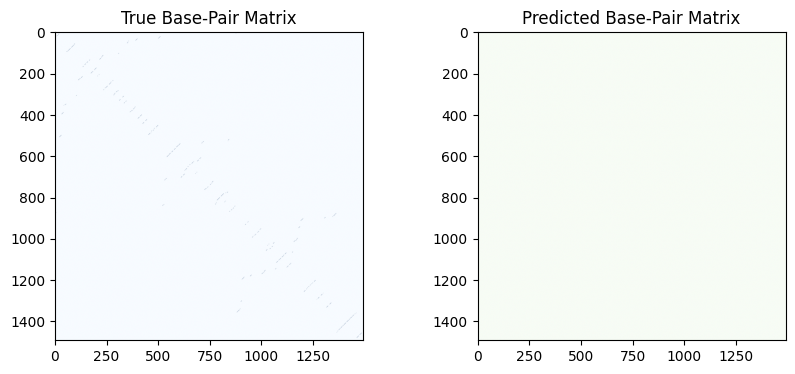

In [21]:
# Visualize true vs. predicted base-pair matrices
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(true_mat0, cmap='Blues')
plt.title("True Base-Pair Matrix")

plt.subplot(1,2,2)
plt.imshow(pred_mat0, cmap='Greens')
plt.title("Predicted Base-Pair Matrix")

plt.show()
